# 🧠 Credit Card Campaign Response Model

Este notebook desarrolla un flujo completo de modelamiento de propensión a respuesta para campañas comerciales de tarjeta de crédito.

Incluye:
1. Exploración de datos (EDA)
2. Limpieza y preprocesamiento
3. Entrenamiento del modelo (Random Forest / XGBoost)
4. Evaluación (ROC, PR, Lift)
5. Interpretabilidad (SHAP opcional)


In [3]:
%pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.3.4-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------------------------------- -- 10.2/11.0 MB 49.8 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 27.7 MB/s  0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------  12.6/12.8 MB 67.5 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 54.4 MB/s  0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 63.8 MB/s  

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Cargar dataset sintético
df = pd.read_csv('C:/Users/User/Downloads/credit_campaign_model/credit_campaign_model/data/credit_campaign_sintetico.csv')
df.head()

,age,income,tenure,education,marital_status,segment,credit_limit,balance,utilization,transactions_3m,...,last_contact_days,last_contact_channel,prev_response,offers_received_6m,delinq_12m,complaints_12m,risk_segment,city,campaign_type,target
0,25,10410.16,18,Tecnico,Casado,Masivo,19399.56,4806.60,0.248,21,...,248,Email,0,2,0,0,Bajo,Trujillo,Cero Interés,0
1,62,13757.55,3,Tecnico,Divorciado,Masivo,5952.48,5358.46,0.900,8,...,58,SMS,1,2,0,0,Alto,Arequipa,Cero Interés,0
2,56,20660.95,6,Postgrado,Casado,Preferente,8915.62,7231.82,0.811,53,...,39,Call,1,1,0,1,Bajo,Lima,Cashback,1
3,44,13171.89,19,Tecnico,Soltero,Preferente,8737.02,6551.03,0.750,60,...,338,App,0,6,0,0,Bajo,Lima,Millas,0
4,44,15690.60,20,Secundaria,Casado,Preferente,18337.35,3109.61,0.170,27,...,260,Email,0,2,0,0,Alto,Lima,Millas,1


## 🔍 Exploración de Datos (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   10000 non-null  int64  
 1   income                9514 non-null   float64
 2   tenure                10000 non-null  int64  
 3   education             10000 non-null  object 
 4   marital_status        10000 non-null  object 
 5   segment               10000 non-null  object 
 6   credit_limit          10000 non-null  float64
 7   balance               10000 non-null  float64
 8   utilization           10000 non-null  float64
 9   transactions_3m       10000 non-null  int64  
 10  avg_spend             10000 non-null  float64
 11  digital_usage         10000 non-null  float64
 12  web_visits_30d        9711 non-null   float64
 13  preferred_channel     9805 non-null   object 
 14  last_contact_days     10000 non-null  int64  
 15  last_contact_channel

,age,income,tenure,credit_limit,balance,utilization,transactions_3m,avg_spend,digital_usage,web_visits_30d,last_contact_days,prev_response,offers_received_6m,delinq_12m,complaints_12m,target
count,10000.00000,9514.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,9711.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,47.30520,20522.421501,12.489800,15009.926801,7498.334018,0.500459,39.32470,250.271995,0.502396,7.586963,182.290200,0.183300,2.009700,0.249400,0.149700,0.294000
std,15.51383,10972.839578,6.988003,6863.220001,5470.154585,0.258509,17.77221,119.132003,0.290682,4.736739,105.425246,0.386932,1.424854,0.588926,0.390263,0.455615
min,21.00000,8000.000000,1.000000,1000.000000,54.400000,0.050000,0.00000,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.00000,12894.212500,6.000000,10266.167500,3058.282500,0.278000,27.00000,166.655000,0.252000,4.000000,91.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,47.00000,17836.540000,13.000000,14948.660000,6313.110000,0.502000,39.00000,248.110000,0.506000,7.000000,183.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,61.00000,25167.280000,18.250000,19589.860000,10783.022500,0.723000,51.00000,331.547500,0.758000,11.000000,274.000000,0.000000,3.000000,0.000000,0.000000,1.000000
max,74.00000,120000.000000,24.000000,44297.750000,35090.960000,0.950000,112.00000,697.660000,1.000000,28.000000,364.000000,1.000000,9.000000,3.000000,3.000000,1.000000


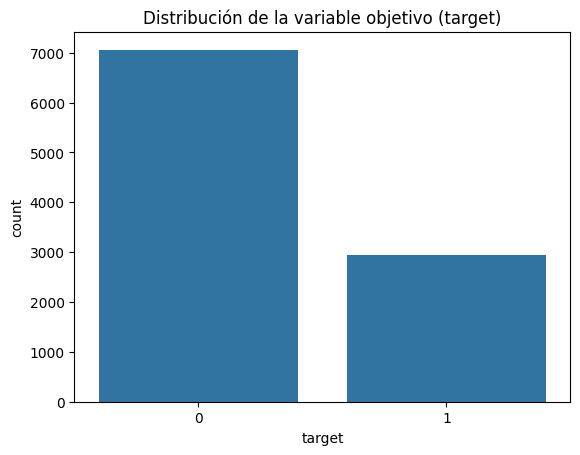

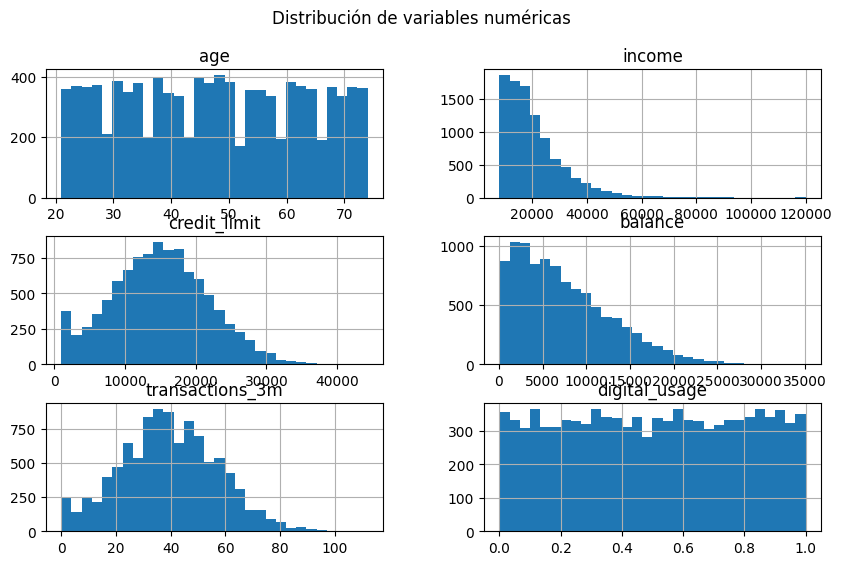

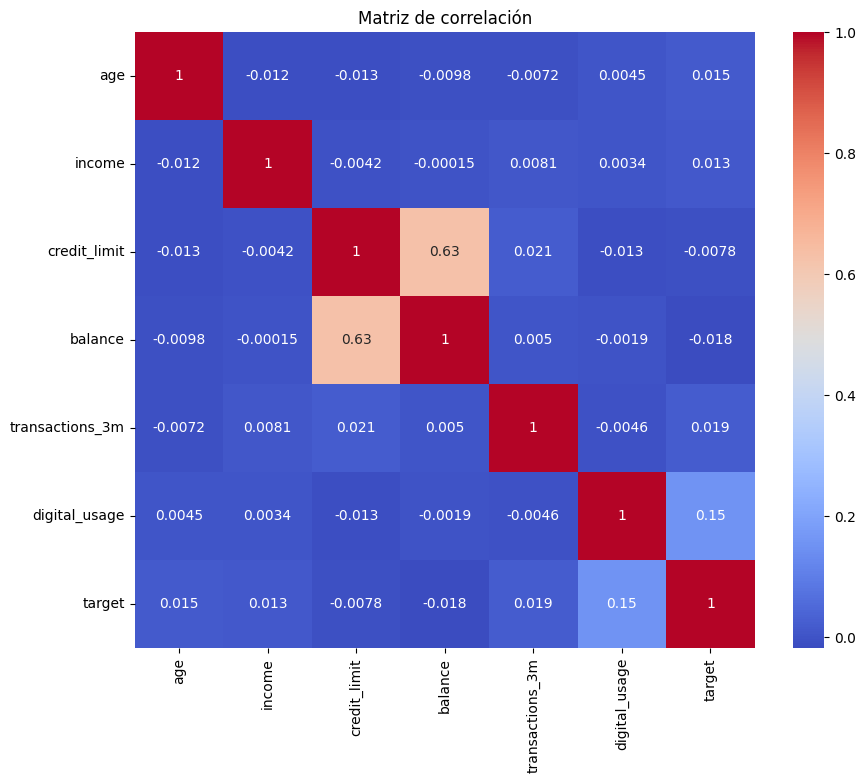

In [5]:
print(df.info())
print('\nEstadísticos descriptivos:')
display(df.describe())

# Distribución de la variable target
sns.countplot(data=df, x='target')
plt.title('Distribución de la variable objetivo (target)')
plt.show()

# Visualización de algunas variables numéricas
num_cols = ['age', 'income', 'credit_limit', 'balance', 'transactions_3m', 'digital_usage']
df[num_cols].hist(bins=30, figsize=(10,6))
plt.suptitle('Distribución de variables numéricas')
plt.show()

# Matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ['target']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

## 🧹 Limpieza y Preprocesamiento


In [6]:
# Imputar nulos
df_model = df.copy()
for col in df_model.select_dtypes(include=[np.number]):
    df_model[col] = df_model[col].fillna(df_model[col].median())
for col in df_model.select_dtypes(exclude=[np.number]):
    df_model[col] = df_model[col].fillna(df_model[col].mode()[0])

X = df_model.drop(columns=['target'])
y = df_model['target']

cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
])

## ⚙️ Entrenamiento del Modelo (Random Forest)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('model', rf)
])

pipe.fit(X_train, y_train)

y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print('AUC:', roc_auc_score(y_test, y_prob))
print('PR AUC:', average_precision_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

AUC: 0.6560904106685167
PR AUC: 0.43480123202615745
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1412
           1       0.59      0.07      0.12       588

    accuracy                           0.71      2000
   macro avg       0.65      0.52      0.48      2000
weighted avg       0.68      0.71      0.62      2000



## 📊 Evaluación: Curvas ROC, PR y Lift


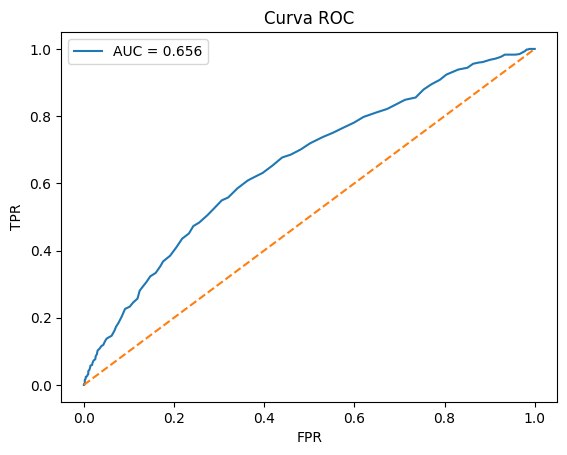

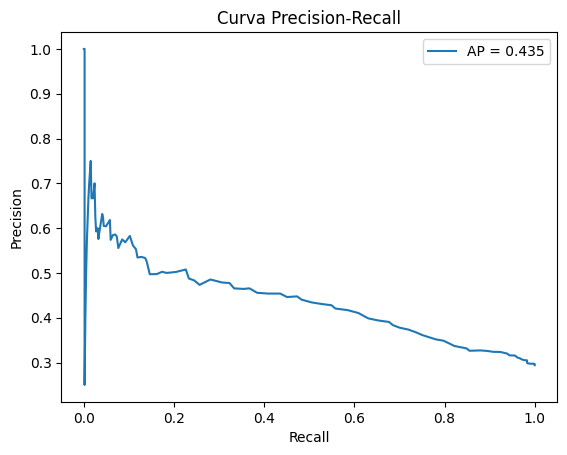

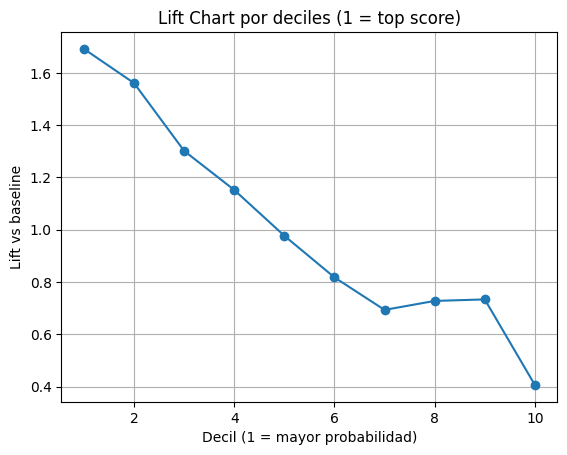

In [8]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Curva Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec, label=f'AP = {average_precision_score(y_test, y_prob):.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Lift chart
eval_df = pd.DataFrame({'prob': y_prob, 'target': y_test})
eval_df['decile'] = pd.qcut(eval_df['prob'], 10, labels=False, duplicates='drop')
lift_table = eval_df.groupby('decile')['target'].mean().sort_index(ascending=False)
baseline = eval_df['target'].mean()

plt.plot(range(1, len(lift_table)+1), lift_table.values / baseline, marker='o')
plt.title('Lift Chart por deciles (1 = top score)')
plt.xlabel('Decil (1 = mayor probabilidad)')
plt.ylabel('Lift vs baseline')
plt.grid(True)
plt.show()